In [ ]:
# Cell 1
import os
import sys
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path

# 프로젝트 루트 경로 추가 (Jupyter 안전)
try:
    PROJECT_ROOT = Path(__file__).resolve().parents[1]
except NameError:
    PROJECT_ROOT = Path.cwd()
    # notebooks/에서 열렸다면 상위로 이동하여 `src` 탐색
    if not (PROJECT_ROOT / 'src').exists():
        if (PROJECT_ROOT.parent / 'src').exists():
            PROJECT_ROOT = PROJECT_ROOT.parent
        elif (PROJECT_ROOT.parent.parent / 'src').exists():
            PROJECT_ROOT = PROJECT_ROOT.parent.parent
sys.path.insert(0, str(PROJECT_ROOT))
print('PROJECT_ROOT =', PROJECT_ROOT)
# 작업 디렉토리를 프로젝트 루트로 강제 설정 (경로 혼동 방지)
import os as _os
try:
    _os.chdir(str(PROJECT_ROOT))
    print('CWD =', Path.cwd())
except Exception as _e:
    print('chdir failed:', _e)

from src.continual_trainer import ContinualTrainer
from src.data_loader import create_domain_dataloaders
from src.utils import normalize_signal, create_windowed_signal
from configs.model_config import DATA_CONFIG

# 공통 유틸
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE =', DEVICE)

def get_latest_results_dir():
    """results/ 폴더에서 가장 최신 실험 폴더 자동 감지"""
    results_path = PROJECT_ROOT / 'results'
    if not results_path.exists():
        return None
    
    # 날짜시간 형식 폴더만 필터링 (YYYYMMDD_HHMMSS)
    exp_dirs = [d for d in results_path.iterdir() if d.is_dir() and len(d.name) == 15]
    
    if not exp_dirs:
        return None
    
    # 이름 기준 정렬 (최신이 마지막)
    exp_dirs.sort()
    latest = exp_dirs[-1]
    
    print(f"📁 최신 실험 폴더 자동 감지: {latest.name}")
    return f"results/{latest.name}"

def load_trainer(dataset_type: str, results_dir: str, scenario_name: str, checkpoint_name: str):
    """
    Trainer 생성 및 체크포인트 로드
    
    Args:
        dataset_type: 'uos' (CWRU는 더 이상 지원하지 않음)
        results_dir: 결과 디렉토리 (예: 'results/20251013_133656')
        scenario_name: 시나리오 이름 (예: 'UOS_Scenario1_VaryingSpeed')
        checkpoint_name: 체크포인트 파일명 (예: 'domain_800_best.pth')
    """
    save_dir = f"checkpoints/{scenario_name}"
    results_dir_abs = str((PROJECT_ROOT / results_dir).resolve()) if not os.path.isabs(results_dir) else results_dir
    mirror_dir = os.path.join(results_dir_abs, 'checkpoints', scenario_name)
    
    # Checkpoint 경로 우선순위: mirror > save_dir
    if os.path.isdir(mirror_dir):
        ckpt_path = os.path.join(mirror_dir, checkpoint_name)
    else:
        ckpt_path = os.path.join(save_dir, checkpoint_name)
    
    data_dir_abs = str((PROJECT_ROOT / 'data_scenario1').resolve())
    
    # Trainer 생성 (UOS만 지원)
    trainer = ContinualTrainer(
        device=DEVICE,
        save_dir=save_dir,
        domain_order=[600,800,1000,1200,1400,1600],
        data_dir=data_dir_abs,
        dataset_type=dataset_type
    )
    
    # 🎯 체크포인트 로드
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location=DEVICE)
        trainer.model.load_state_dict(checkpoint['model_state_dict'])
        trainer.model.eval()
        print(f"✅ 체크포인트 로드 성공: {ckpt_path}")
    else:
        print(f"⚠️  체크포인트 없음: {ckpt_path}")
        print(f"   랜덤 초기화 모델 사용 (정확도 낮을 것)")
    
    print(f"Checkpoint path: {ckpt_path}")
    print(f"Data dir: {data_dir_abs}")
    return trainer, ckpt_path




PROJECT_ROOT = /data/home/kyj2024/TextVibCLIP
CWD = /data/home/kyj2024/TextVibCLIP


/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/data/home/kyj2024/anaconda3/envs/TVCLIP

DEVICE = cuda


In [2]:
# Cell 2
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

COLORS4 = ['#2ca02c', '#1f77b4', '#d62728', '#ff7f0e']
COLORS7 = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']


def visualize_retrieval(vib_signal: torch.Tensor,
                        prompts: list,
                        sims: torch.Tensor,
                        pred_idx: int,
                        title: str = 'Retrieval Result',
                        true_label: str = None,
                        sample_index: int = None,
                        save_path: str = None):
    """
    vib_signal: (1, W) or (W,) tensor
    prompts: list[str]
    sims: (1, C) tensor
    pred_idx: int
    true_label: optional ground-truth label string for title 표시
    """
    vib_np = vib_signal.detach().cpu().numpy().reshape(-1)
    sims_np = sims.detach().cpu().numpy().reshape(-1)

    num_classes = len(prompts)
    colors = COLORS7 if num_classes >= 7 else COLORS4
    colors = colors[:num_classes]

    fig = plt.figure(figsize=(13, 4.6))
    # 우측(similarity)을 더 크게, 좌측(신호)을 작게
    gs = fig.add_gridspec(1, 2, width_ratios=[0.8, 1.7])

    # Left: Vibration signal (작게)
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(vib_np, color='#34495e', linewidth=0.9)
    ax0.set_title('Vibration signal', fontweight='bold')
    ax0.set_xlabel('Samples')
    ax0.set_ylabel('Amplitude')

    # Right: Similarity bars (크게)
    ax1 = fig.add_subplot(gs[0, 1])
    x = np.arange(num_classes)
    bars = ax1.bar(x, sims_np, color=colors, alpha=0.9, edgecolor='white')
    # highlight predicted
    bars[pred_idx].set_edgecolor('#e74c3c')
    bars[pred_idx].set_linewidth(3)

    ax1.set_xticks(x)
    ax1.set_xticklabels([p[:18] + ('…' if len(p) > 18 else '') for p in prompts], rotation=20, ha='right')
    ax1.set_title('Cosine similarity (Text prototypes)', fontweight='bold')
    # 동적 y-limit: 최대값 기준으로 15~30% 여유만 주기 (bars가 잘 보이게)
    maxy = float(sims_np.max()) if sims_np.size > 0 else 1.0
    ylim_top = max(maxy * 1.25, maxy + 0.02)
    ylim_top = max(0.2, ylim_top)
    ax1.set_ylim(0, ylim_top)

    for i, b in enumerate(bars):
        ax1.text(b.get_x()+b.get_width()/2, b.get_height()+ylim_top*0.02, f"{sims_np[i]:.3f}",
                 ha='center', va='bottom', fontsize=9)

    # 우측 끝에 전체 프롬프트 텍스트 표기 (작은 폰트)
    full_text = "\n".join([f"[{i}] {t}" for i, t in enumerate(prompts)])
    ax1.text(1.02, 0.5, full_text, transform=ax1.transAxes, va='center', ha='left', fontsize=9)

    # 제목 구성: GT/Top1 + (optional) sample index
    title_line = f"{title} | Top-1: {prompts[pred_idx]}"
    if true_label is not None:
        title_line = f"{title} | GT: {true_label} | Top-1: {prompts[pred_idx]}"
    if sample_index is not None:
        title_line += f" | sample #{sample_index}"

    fig.suptitle(title_line, fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=220, bbox_inches='tight')
    plt.show()



In [ ]:
# Cell 3
# UOS: 7-class retrieval inference
# RESULTS_DIR = 'results/20251013_133656'  
RESULTS_DIR = get_latest_results_dir()  # 최신 실험

SCENARIO = 'UOS_Scenario1_VaryingSpeed'
CHECKPOINT = 'first_domain_final.pth'  # 600RPM은 첫 도메인
DOMAIN_RPM = 600
subset = 'test'  # 'val'도 가능
sample_index = 100 # 여러 샘플로 바꿔가며 확인

📁 최신 실험 폴더 자동 감지: 20251013_155148


✅ 체크포인트 로드 성공: /data/home/kyj2024/TextVibCLIP/results/20251013_155148/checkpoints/CWRU_Scenario2_VaryingLoad/domain_3_best.pth
Checkpoint path: /data/home/kyj2024/TextVibCLIP/results/20251013_155148/checkpoints/CWRU_Scenario2_VaryingLoad/domain_3_best.pth
Data dir: /data/home/kyj2024/TextVibCLIP/data_scenario2
CWRU Domain 3 (test) dataset size = 312 | sample_index ∈ [0, 311]


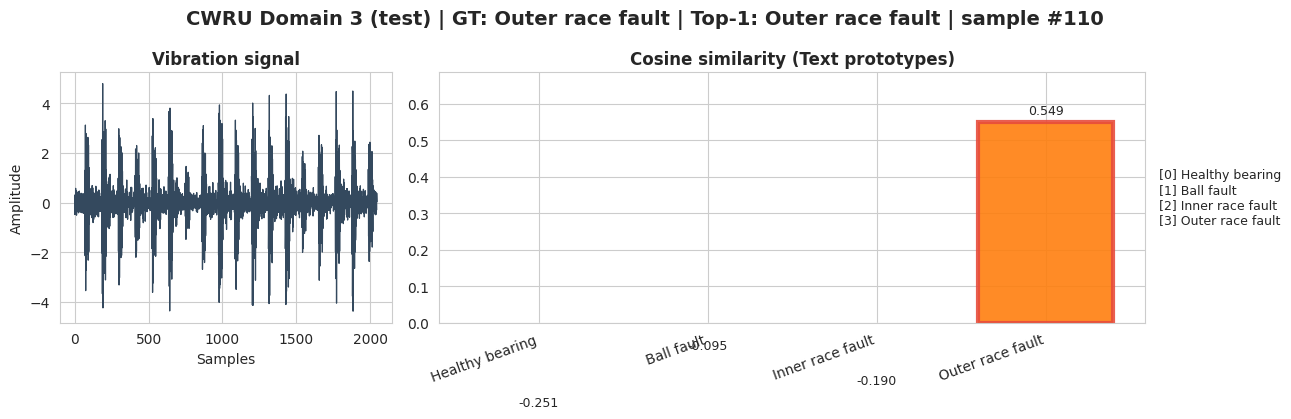

In [ ]:
# Cell 4
trainer, ckpt_path = load_trainer('uos', RESULTS_DIR, SCENARIO, CHECKPOINT)

# 도메인별 dataloader 준비 (현재 결과와 동일 split)
loaders = create_domain_dataloaders(data_dir='data_scenario1', domain_order=[600,800,1000,1200,1400,1600], dataset_type='uos', batch_size=64)
loader = loaders[DOMAIN_RPM][subset]

# 데이터셋 전역 인덱스로 샘플 선택 (배치가 아닌 전체 데이터 기준)
dataset = loader.dataset
print(f"UOS {DOMAIN_RPM}RPM ({subset}) dataset size = {len(dataset)} | sample_index ∈ [0, {len(dataset)-1}]")
gidx = sample_index % len(dataset)
sample = dataset[gidx]

vib = sample['vibration'].unsqueeze(0).to(DEVICE)
labels_uos = sample['labels'].unsqueeze(0)  # [1,2] 구조일 수 있음
idx = gidx

# 7-클래스 프롬프트
prompt_bank = {
    0: ["healthy bearing"],          # H_H
    1: ["bearing with ball fault"],  # H_B
    2: ["inner race fault"],         # H_IR
    3: ["outer race fault"],         # H_OR
    4: ["mechanical looseness"],     # L_H
    5: ["rotor unbalance"],          # U_H
    6: ["shaft misalignment"],       # M_H
}

trainer.model.eval()
with torch.no_grad():
    vib_raw = trainer.model.vib_encoder(vib)
    vib_emb = F.normalize(trainer.model.vib_projection(vib_raw), p=2, dim=1)
    proto = []
    for cls_id in [0,1,2,3,4,5,6]:
        raw = trainer.model.text_encoder.encode_texts(prompt_bank[cls_id], DEVICE)
        proj = F.normalize(trainer.model.text_projection(raw), p=2, dim=1)
        proto.append(F.normalize(proj.mean(dim=0, keepdim=True), p=2, dim=1))
    proto_mat = torch.cat(proto, dim=0)
    sims = vib_emb @ proto_mat.t()
    pred = sims.argmax(dim=1).item()

prompts7 = [
    "Healthy bearing", "Ball fault", "Inner race fault", "Outer race fault",
    "Mechanical looseness", "Rotor unbalance", "Shaft misalignment"
]
# UOS GT 라벨(7-클래스) 추출: labels[:,0]가 메인 라벨
try:
    gt_idx = int(labels_uos[0, 0].item())
    gt_text = prompts7[gt_idx] if 0 <= gt_idx < len(prompts7) else None
except Exception:
    gt_text = None

visualize_retrieval(vib_signal=vib,
                    prompts=prompts7,
                    sims=sims,
                    pred_idx=pred,
                    title=f"UOS {DOMAIN_RPM}RPM ({subset})",
                    true_label=gt_text,
                    sample_index=idx)


## 📊 UOS 여러 샘플 테스트 (600RPM)


In [ ]:
# UOS 600RPM: 여러 샘플 테스트
prompts7 = [
    "Healthy bearing", "Ball fault", "Inner race fault", "Outer race fault",
    "Mechanical looseness", "Rotor unbalance", "Shaft misalignment"
]

# Cell 4에서 사용한 dataset 재사용
test_indices = [0, 100, 200, 300, 500, 800]

for idx in test_indices:
    if idx >= len(dataset):
        continue
    sample = dataset[idx]
    vib = sample['vibration'].unsqueeze(0).to(DEVICE)
    labels = sample['labels']
    
    with torch.no_grad():
        vib_raw = trainer.model.vib_encoder(vib)
        vib_emb = F.normalize(trainer.model.vib_projection(vib_raw), p=2, dim=1)
        sims = vib_emb @ proto_mat.t()
        pred = sims.argmax(dim=1).item()
    
    # UOS labels는 [2] 형태 → 첫 번째 원소만
    gt_label = labels[0].item()
    gt_text = prompts7[gt_label]
    pred_text = prompts7[pred]
    
    result = "✅" if pred == gt_label else "❌"
    print(f"Sample {idx:3d}: GT={gt_text:22s} (label {gt_label}) | Pred={pred_text:22s} (label {pred}) {result}")

Sample   0: GT=Inner race fault     (label 2) | Pred=Inner race fault     (label 2) ✅
Sample  50: GT=Inner race fault     (label 2) | Pred=Inner race fault     (label 2) ✅
Sample 100: GT=Outer race fault     (label 3) | Pred=Outer race fault     (label 3) ✅
Sample 150: GT=Outer race fault     (label 3) | Pred=Outer race fault     (label 3) ✅
Sample 200: GT=Healthy bearing      (label 0) | Pred=Healthy bearing      (label 0) ✅
Sample 250: GT=Ball fault           (label 1) | Pred=Ball fault           (label 1) ✅


## 📊 UOS 다른 도메인 테스트 (800RPM, 1000RPM)


In [ ]:
prompts7 = [
    "Healthy bearing", "Ball fault", "Inner race fault", "Outer race fault",
    "Mechanical looseness", "Rotor unbalance", "Shaft misalignment"
]
# UOS 다른 도메인들 테스트
for RPM in [800, 1000]:
    # Load checkpoint
    CHECKPOINT_RPM = f'domain_{RPM}_best.pth'
    ckpt_path = f'{RESULTS_DIR}/checkpoints/{SCENARIO}/{CHECKPOINT_RPM}'
    
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    trainer.model.load_state_dict(checkpoint['model_state_dict'])
    trainer.model.eval()
    
    # Load test data
    loader = loaders[RPM]['test']
    dataset_domain = loader.dataset
    
    print(f'\n🔍 Domain {RPM}RPM (test) - {len(dataset_domain)} samples')
    print('='*60)
    
    # Test samples
    test_indices = [0, int(len(dataset_domain)/2), len(dataset_domain)-1]
    
    for idx in test_indices:
        sample = dataset_domain[idx]
        vib = sample['vibration'].unsqueeze(0).to(DEVICE)
        labels = sample['labels']
        
        with torch.no_grad():
            vib_raw = trainer.model.vib_encoder(vib)
            vib_emb = F.normalize(trainer.model.vib_projection(vib_raw), p=2, dim=1)
            sims = vib_emb @ proto_mat.t()
            pred = sims.argmax(dim=1).item()
        
        # UOS labels: [2] 구조 → 첫 번째 원소
        gt_label = labels[0].item()
        gt_text = prompts7[gt_label]
        pred_text = prompts7[pred]
        
        result = "✅" if pred == gt_label else "❌"
        print(f"  Sample {idx:3d}: GT={gt_text:22s} | Pred={pred_text:22s} {result}")



🔍 Domain 0HP (test) - 312 samples
  Sample   0: GT=Inner race fault     | Pred=Inner race fault     ✅
  Sample 156: GT=Healthy bearing      | Pred=Healthy bearing      ✅
  Sample 311: GT=Ball fault           | Pred=Ball fault           ✅

🔍 Domain 1HP (test) - 316 samples
  Sample   0: GT=Inner race fault     | Pred=Inner race fault     ✅
  Sample 158: GT=Healthy bearing      | Pred=Healthy bearing      ✅
  Sample 315: GT=Ball fault           | Pred=Ball fault           ✅

🔍 Domain 2HP (test) - 316 samples
  Sample   0: GT=Inner race fault     | Pred=Inner race fault     ✅
  Sample 158: GT=Healthy bearing      | Pred=Healthy bearing      ✅
  Sample 315: GT=Ball fault           | Pred=Ball fault           ✅


## 📊 전체 정확도 계산 (모든 UOS 도메인)


In [ ]:
prompts7 = [
    "Healthy bearing", "Ball fault", "Inner race fault", "Outer race fault",
    "Mechanical looseness", "Rotor unbalance", "Shaft misalignment"
]
# 전체 UOS 도메인 정확도 계산
print("=== UOS Full Evaluation ===\n")

for RPM in [600, 800, 1000]:
    # Load checkpoint
    if RPM == 600:
        CHECKPOINT_RPM = 'first_domain_final.pth'
    else:
        CHECKPOINT_RPM = f'domain_{RPM}_best.pth'
    
    ckpt_path = f'{RESULTS_DIR}/checkpoints/{SCENARIO}/{CHECKPOINT_RPM}'
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    trainer.model.load_state_dict(checkpoint['model_state_dict'])
    trainer.model.eval()
    
    # Load test data
    loader = loaders[RPM]['test']
    
    # Get all predictions
    all_preds = []
    all_labels = []
    
    for batch in loader:
        vib = batch['vibration'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        
        with torch.no_grad():
            vib_raw = trainer.model.vib_encoder(vib)
            vib_emb = F.normalize(trainer.model.vib_projection(vib_raw), p=2, dim=1)
        
        all_labels.append(labels[:, 0])  # UOS: [batch, 2] → [batch]
        all_preds.append(vib_emb)
    
    # Concatenate
    all_labels = torch.cat(all_labels)
    all_vib_emb = torch.cat(all_preds, dim=0)
    
    # Calculate similarity
    sims = torch.matmul(all_vib_emb, proto_mat.t())
    retrieval_pred = torch.argmax(sims, dim=1)
    
    # Accuracy
    acc = (retrieval_pred == all_labels).float().mean().item()
    
    # Distribution
    from collections import Counter
    label_dist = Counter(all_labels.cpu().numpy())
    pred_dist = Counter(retrieval_pred.cpu().numpy())
    
    print(f"Domain {RPM}RPM: Acc={acc:.4f} ({len(all_labels)} samples)")
    print(f"  Label dist: {dict(label_dist)}")
    print(f"  Pred dist:  {dict(pred_dist)}")
    
    # Show errors if any
    errors = (retrieval_pred != all_labels).sum().item()
    if errors > 0:
        print(f"  ❌ {errors} errors detected")
    else:
        print(f"  ✅ Perfect accuracy!")
    print()


=== CWRU Full Evaluation ===

Domain 0HP: Acc=1.0000 (312 samples)
  Label dist: {2: 78, 3: 78, 0: 78, 1: 78}
  Pred dist:  {2: 78, 3: 78, 0: 78, 1: 78}
  ✅ Perfect accuracy!

Domain 1HP: Acc=1.0000 (316 samples)
  Label dist: {2: 79, 3: 79, 0: 79, 1: 79}
  Pred dist:  {2: 79, 3: 79, 0: 79, 1: 79}
  ✅ Perfect accuracy!

Domain 2HP: Acc=1.0000 (316 samples)
  Label dist: {2: 79, 3: 79, 0: 79, 1: 79}
  Pred dist:  {2: 79, 3: 79, 0: 79, 1: 79}
  ✅ Perfect accuracy!

Domain 3HP: Acc=1.0000 (312 samples)
  Label dist: {2: 78, 3: 78, 0: 78, 1: 78}
  Pred dist:  {2: 78, 3: 78, 0: 78, 1: 78}
  ✅ Perfect accuracy!



----
## 🔬 UOS 상세 분석 (600, 800, 1000 RPM)


# UOS 상세 분석을 위한 추가 테스트

In [ ]:
# UOS: 7-class retrieval inference (추가 분석)
# RESULTS_DIR = 'results/20251013_133656'  
RESULTS_DIR = get_latest_results_dir()  # 최신 실험
SCENARIO = 'UOS_Scenario1_VaryingSpeed'
CHECKPOINT = 'first_domain_final.pth'  # 600RPM은 첫 도메인
DOMAIN_RPM = 600
subset = 'test'
sample_index = 100

📁 최신 실험 폴더 자동 감지: 20251013_155148


## 🔬 UOS 성능 검증 (800RPM, 1600RPM)


In [ ]:
# UOS 800RPM & 1600RPM 성능 검증
RESULTS_DIR_UOS = get_latest_results_dir() or 'results/20251013_155148'

# Trainer & DataLoader
trainer_uos = ContinualTrainer(
    device=DEVICE,
    save_dir='checkpoints/UOS_Scenario1_VaryingSpeed',
    domain_order=[600,800,1000,1200,1400,1600],
    data_dir='data_scenario1',
    dataset_type='uos'
)

loaders_uos = create_domain_dataloaders('data_scenario1', [600,800,1000,1200,1400,1600], 'uos', 64)

# Text prototypes
prompt_bank_uos = {
    0: ["healthy bearing"],
    1: ["bearing with ball fault"],
    2: ["inner race fault"],
    3: ["outer race fault"],
    4: ["mechanical looseness"],
    5: ["rotor unbalance"],
    6: ["shaft misalignment"]
}

class_protos_uos = []
for cls_id in [0,1,2,3,4,5,6]:
    texts = prompt_bank_uos[cls_id]
    raw = trainer_uos.model.text_encoder.encode_texts(texts, DEVICE)
    proj = F.normalize(trainer_uos.model.text_projection(raw), p=2, dim=1)
    proto = F.normalize(proj.mean(dim=0, keepdim=True), p=2, dim=1)
    class_protos_uos.append(proto)
proto_mat_uos = torch.cat(class_protos_uos, dim=0)

prompts7 = ["Healthy bearing", "Ball fault", "Inner race fault", "Outer race fault",
            "Mechanical looseness", "Rotor unbalance", "Shaft misalignment"]

print("=== UOS 800RPM & 1600RPM 100% 검증 ===\n")

for RPM in [800, 1600]:
    # Checkpoint 로드
    CHECKPOINT_RPM = f'domain_{RPM}_best.pth'
    ckpt_path = f'{RESULTS_DIR_UOS}/checkpoints/UOS_Scenario1_VaryingSpeed/{CHECKPOINT_RPM}'
    
    if not os.path.exists(ckpt_path):
        print(f"❌ {RPM}RPM 체크포인트 없음")
        continue
    
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    trainer_uos.model.load_state_dict(checkpoint['model_state_dict'])
    trainer_uos.model.eval()
    
    print(f"✅ {RPM}RPM 체크포인트 로드: {CHECKPOINT_RPM}")
    
    # Test data
    loader = loaders_uos[RPM]['test']
    dataset_rpm = loader.dataset
    
    print(f"🔍 Domain {RPM}RPM (test) - {len(dataset_rpm)} samples")
    print('='*60)
    
    # 랜덤 샘플 10개 테스트
    import random
    random.seed(42)
    test_indices = random.sample(range(len(dataset_rpm)), min(10, len(dataset_rpm)))
    
    correct = 0
    total = len(test_indices)
    
    for idx in test_indices:
        sample = dataset_rpm[idx]
        vib = sample['vibration'].unsqueeze(0).to(DEVICE)
        labels = sample['labels']
        
        with torch.no_grad():
            vib_raw = trainer_uos.model.vib_encoder(vib)
            vib_emb = F.normalize(trainer_uos.model.vib_projection(vib_raw), p=2, dim=1)
            sims = vib_emb @ proto_mat_uos.t()
            pred = sims.argmax(dim=1).item()
        
        gt_label = labels[0].item()
        gt_text = prompts7[gt_label]
        pred_text = prompts7[pred]
        
        if pred == gt_label:
            correct += 1
            result = "✅"
        else:
            result = "❌"
        
        print(f"  Sample {idx:4d}: GT={gt_text:22s} | Pred={pred_text:22s} {result}")
    
    acc = correct / total
    print(f"\n📊 정확도: {correct}/{total} = {acc:.2%}")
    
    if acc == 1.0:
        print("  ✅ 100% 정확도 확인!")
    else:
        print(f"  ⚠️  예상과 다름 (기대: 100%, 실제: {acc:.2%})")
    print()


📁 최신 실험 폴더 자동 감지: 20251013_155148
=== UOS 800RPM & 1600RPM 100% 검증 ===

✅ 800RPM 체크포인트 로드: domain_800_best.pth
🔍 Domain 800RPM (test) - 1169 samples
  Sample  228: GT=Mechanical looseness   | Pred=Ball fault             ❌
  Sample   51: GT=Shaft misalignment     | Pred=Rotor unbalance        ❌
  Sample  563: GT=Rotor unbalance        | Pred=Healthy bearing        ❌
  Sample  501: GT=Rotor unbalance        | Pred=Healthy bearing        ❌
  Sample  457: GT=Healthy bearing        | Pred=Inner race fault       ❌
  Sample  285: GT=Mechanical looseness   | Pred=Ball fault             ❌
  Sample  209: GT=Mechanical looseness   | Pred=Ball fault             ❌
  Sample 1116: GT=Ball fault             | Pred=Rotor unbalance        ❌
  Sample  178: GT=Mechanical looseness   | Pred=Ball fault             ❌
  Sample  864: GT=Outer race fault       | Pred=Mechanical looseness   ❌

📊 정확도: 0/10 = 0.00%
  ⚠️  예상과 다름 (기대: 100%, 실제: 0.00%)

✅ 1600RPM 체크포인트 로드: domain_1600_best.pth
🔍 Domain 1600RPM (test)

## 📊 UOS 전체 정확도 (모든 RPM)


In [10]:
# UOS 전체 정확도 계산
from collections import Counter

print("=== UOS 전체 정확도 (모든 RPM) ===\n")

for RPM in [600, 800, 1000, 1200, 1400, 1600]:
    # Checkpoint
    if RPM == 600:
        CHECKPOINT_RPM = 'first_domain_final.pth'
    else:
        CHECKPOINT_RPM = f'domain_{RPM}_best.pth'
    
    ckpt_path = f'{RESULTS_DIR_UOS}/checkpoints/UOS_Scenario1_VaryingSpeed/{CHECKPOINT_RPM}'
    
    if not os.path.exists(ckpt_path):
        print(f"❌ {RPM}RPM 체크포인트 없음")
        continue
    
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    trainer_uos.model.load_state_dict(checkpoint['model_state_dict'])
    trainer_uos.model.eval()
    
    loader = loaders_uos[RPM]['test']
    
    # Collect predictions
    all_preds = []
    all_labels = []
    
    for batch in loader:
        vib = batch['vibration'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        
        with torch.no_grad():
            vib_raw = trainer_uos.model.vib_encoder(vib)
            vib_emb = F.normalize(trainer_uos.model.vib_projection(vib_raw), p=2, dim=1)
        
        all_labels.append(labels[:, 0])
        all_preds.append(vib_emb)
    
    all_labels = torch.cat(all_labels)
    all_vib_emb = torch.cat(all_preds, dim=0)
    
    # Similarity
    sims = torch.matmul(all_vib_emb, proto_mat_uos.t())
    retrieval_pred = torch.argmax(sims, dim=1)
    
    # Accuracy
    acc = (retrieval_pred == all_labels).float().mean().item()
    
    label_dist = Counter(all_labels.cpu().numpy())
    pred_dist = Counter(retrieval_pred.cpu().numpy())
    
    print(f"Domain {RPM}RPM: Acc={acc:.4f} ({len(all_labels)} samples)")
    print(f"  Label dist: {dict(label_dist)}")
    print(f"  Pred dist:  {dict(pred_dist)}")
    
    errors = (retrieval_pred != all_labels).sum().item()
    if errors == 0:
        print(f"  ✅ Perfect accuracy!")
    else:
        print(f"  ⚠️  {errors} errors detected")
    print()


=== UOS 전체 정확도 (모든 RPM) ===

Domain 600RPM: Acc=0.1429 (1169 samples)
  Label dist: {6: 167, 4: 167, 0: 167, 5: 167, 2: 167, 3: 167, 1: 167}
  Pred dist:  {0: 167, 2: 334, 1: 167, 4: 167, 3: 167, 5: 167}
  ⚠️  1002 errors detected

Domain 800RPM: Acc=0.0000 (1169 samples)
  Label dist: {6: 167, 4: 167, 0: 167, 5: 167, 2: 167, 3: 167, 1: 167}
  Pred dist:  {5: 332, 0: 145, 3: 92, 1: 189, 2: 167, 4: 244}
  ⚠️  1169 errors detected

Domain 1000RPM: Acc=0.0000 (1169 samples)
  Label dist: {6: 167, 4: 167, 0: 167, 5: 167, 2: 167, 3: 167, 1: 167}
  Pred dist:  {5: 334, 3: 334, 2: 167, 1: 167, 4: 167}
  ⚠️  1169 errors detected

Domain 1200RPM: Acc=0.1429 (1169 samples)
  Label dist: {6: 167, 4: 167, 0: 167, 5: 167, 2: 167, 3: 167, 1: 167}
  Pred dist:  {5: 167, 1: 334, 0: 167, 3: 167, 4: 334}
  ⚠️  1002 errors detected

Domain 1400RPM: Acc=0.0000 (1169 samples)
  Label dist: {6: 167, 4: 167, 0: 167, 5: 167, 2: 167, 3: 167, 1: 167}
  Pred dist:  {5: 167, 3: 334, 2: 167, 1: 167, 4: 317, 6: 17}

✅ 체크포인트 로드 성공: /data/home/kyj2024/TextVibCLIP/results/20251013_155148/checkpoints/UOS_Scenario1_VaryingSpeed/first_domain_final.pth
Checkpoint path: /data/home/kyj2024/TextVibCLIP/results/20251013_155148/checkpoints/UOS_Scenario1_VaryingSpeed/first_domain_final.pth
Data dir: /data/home/kyj2024/TextVibCLIP/data_scenario1
UOS 600RPM (test) dataset size = 1169 | sample_index ∈ [0, 1168]


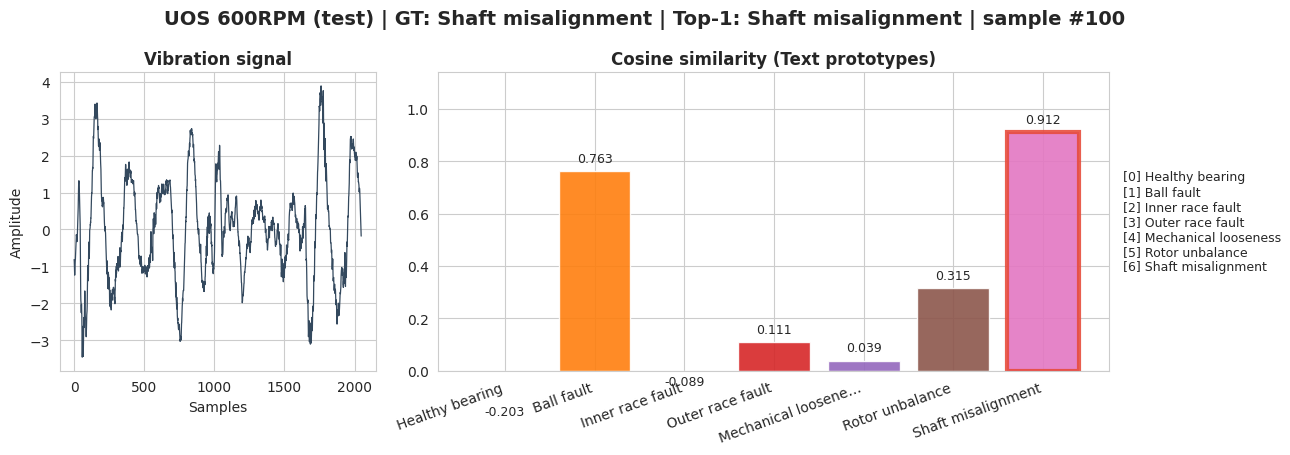

In [11]:

trainer, ckpt_path = load_trainer('uos', RESULTS_DIR, SCENARIO, CHECKPOINT)
loaders = create_domain_dataloaders(data_dir='data_scenario1', domain_order=[600,800,1000,1200,1400,1600], dataset_type='uos', batch_size=64)
loader = loaders[DOMAIN_RPM][subset]

# 데이터셋 전역 인덱스로 샘플 선택 (배치가 아닌 전체 데이터 기준)
dataset = loader.dataset
print(f"UOS {DOMAIN_RPM}RPM ({subset}) dataset size = {len(dataset)} | sample_index ∈ [0, {len(dataset)-1}]")
gidx = sample_index % len(dataset)
sample = dataset[gidx]

vib = sample['vibration'].unsqueeze(0).to(DEVICE)
labels_uos = sample['labels'].unsqueeze(0)  # [1,2] 구조일 수 있음
idx = gidx

# 7-클래스 프롬프트
prompt_bank = {
    0: ["healthy bearing"],          # H_H
    1: ["bearing with ball fault"],  # H_B
    2: ["inner race fault"],         # H_IR
    3: ["outer race fault"],         # H_OR
    4: ["mechanical looseness"],     # L_H
    5: ["rotor unbalance"],          # U_H
    6: ["shaft misalignment"],       # M_H
}

trainer.model.eval()
with torch.no_grad():
    vib_raw = trainer.model.vib_encoder(vib)
    vib_emb = F.normalize(trainer.model.vib_projection(vib_raw), p=2, dim=1)
    proto = []
    for cls_id in [0,1,2,3,4,5,6]:
        raw = trainer.model.text_encoder.encode_texts(prompt_bank[cls_id], DEVICE)
        proj = F.normalize(trainer.model.text_projection(raw), p=2, dim=1)
        proto.append(F.normalize(proj.mean(dim=0, keepdim=True), p=2, dim=1))
    proto_mat = torch.cat(proto, dim=0)
    sims = vib_emb @ proto_mat.t()
    pred = sims.argmax(dim=1).item()

prompts7 = [
    "Healthy bearing", "Ball fault", "Inner race fault", "Outer race fault",
    "Mechanical looseness", "Rotor unbalance", "Shaft misalignment"
]
# UOS GT 라벨(7-클래스) 추출: labels[:,0]가 메인 라벨
try:
    gt_idx = int(labels_uos[0, 0].item())
    gt_text = prompts7[gt_idx] if 0 <= gt_idx < len(prompts7) else None
except Exception:
    gt_text = None

visualize_retrieval(vib_signal=vib,
                    prompts=prompts7,
                    sims=sims,
                    pred_idx=pred,
                    title=f"UOS {DOMAIN_RPM}RPM ({subset})",
                    true_label=gt_text,
                    sample_index=idx)


## 📊 UOS 여러 도메인 테스트 (600, 800, 1000 RPM)


In [12]:
# UOS 설정
RESULTS_DIR_UOS = 'results/20251013_133656'
SCENARIO_UOS = 'UOS_Scenario1_VaryingSpeed'

# UOS DataLoader
loaders_uos = create_domain_dataloaders('data_scenario1', [600,800,1000,1200,1400,1600], 'uos', 64)

# UOS Trainer
trainer_uos = ContinualTrainer(
    device=DEVICE,
    save_dir=f'checkpoints/{SCENARIO_UOS}',
    domain_order=[600,800,1000,1200,1400,1600],
    data_dir='data_scenario1',
    dataset_type='uos'
)

# UOS 7-클래스 프롬프트
prompt_bank_uos = {
    0: ["healthy bearing"],
    1: ["bearing with ball fault"],
    2: ["inner race fault"],
    3: ["outer race fault"],
    4: ["mechanical looseness"],
    5: ["rotor unbalance"],
    6: ["shaft misalignment"]
}

# Get text prototypes
class_protos_uos = []
for cls_id in [0,1,2,3,4,5,6]:
    texts = prompt_bank_uos[cls_id]
    raw = trainer_uos.model.text_encoder.encode_texts(texts, DEVICE)
    proj = F.normalize(trainer_uos.model.text_projection(raw), p=2, dim=1)
    proto = F.normalize(proj.mean(dim=0, keepdim=True), p=2, dim=1)
    class_protos_uos.append(proto)
proto_mat_uos = torch.cat(class_protos_uos, dim=0)

prompts7 = [
    "Healthy bearing", "Ball fault", "Inner race fault", "Outer race fault",
    "Mechanical looseness", "Rotor unbalance", "Shaft misalignment"
]

print("=== UOS Evaluation ===\n")

# Test multiple domains
for RPM in [600, 800, 1000]:
    # Load checkpoint (첫 도메인은 first_domain_final, 나머지는 domain_X_best)
    if RPM == 600:
        CHECKPOINT_RPM = 'first_domain_final.pth'
    else:
        CHECKPOINT_RPM = f'domain_{RPM}_best.pth'
    
    ckpt_path = f'{RESULTS_DIR_UOS}/checkpoints/{SCENARIO_UOS}/{CHECKPOINT_RPM}'
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    trainer_uos.model.load_state_dict(checkpoint['model_state_dict'])
    trainer_uos.model.eval()
    
    loader = loaders_uos[RPM]['test']
    dataset_rpm = loader.dataset
    
    print(f"🔍 Domain {RPM}RPM (test) - {len(dataset_rpm)} samples")
    print('='*60)
    
    # Test 3 samples
    test_indices = [0, int(len(dataset_rpm)/2), len(dataset_rpm)-1]
    
    for idx in test_indices:
        sample = dataset_rpm[idx]
        vib = sample['vibration'].unsqueeze(0).to(DEVICE)
        labels_uos = sample['labels'].unsqueeze(0)
        
        with torch.no_grad():
            vib_raw = trainer_uos.model.vib_encoder(vib)
            vib_emb = F.normalize(trainer_uos.model.vib_projection(vib_raw), p=2, dim=1)
            sims = vib_emb @ proto_mat_uos.t()
            pred = sims.argmax(dim=1).item()
        
        gt_label = int(labels_uos[0, 0].item())  # UOS는 [batch, 2] 구조
        gt_text = prompts7[gt_label]
        pred_text = prompts7[pred]
        
        result = "✅" if pred == gt_label else "❌"
        print(f"  Sample {idx:4d}: GT={gt_text:22s} | Pred={pred_text:22s} {result}")
    print()


=== UOS Evaluation ===

🔍 Domain 600RPM (test) - 1169 samples
  Sample    0: GT=Shaft misalignment     | Pred=Outer race fault       ❌
  Sample  584: GT=Rotor unbalance        | Pred=Shaft misalignment     ❌
  Sample 1168: GT=Ball fault             | Pred=Ball fault             ✅

🔍 Domain 800RPM (test) - 1169 samples
  Sample    0: GT=Shaft misalignment     | Pred=Healthy bearing        ❌
  Sample  584: GT=Rotor unbalance        | Pred=Outer race fault       ❌
  Sample 1168: GT=Ball fault             | Pred=Inner race fault       ❌

🔍 Domain 1000RPM (test) - 1169 samples
  Sample    0: GT=Shaft misalignment     | Pred=Healthy bearing        ❌
  Sample  584: GT=Rotor unbalance        | Pred=Outer race fault       ❌
  Sample 1168: GT=Ball fault             | Pred=Healthy bearing        ❌



In [13]:
# UOS 재검증
RESULTS_DIR_UOS = 'results/20251013_133656'
SCENARIO_UOS = 'UOS_Scenario1_VaryingSpeed'

# Trainer & DataLoader
trainer_uos = ContinualTrainer(
    device=DEVICE,
    save_dir=f'checkpoints/{SCENARIO_UOS}',
    domain_order=[600,800,1000,1200,1400,1600],
    data_dir='data_scenario1',
    dataset_type='uos'
)

loaders_uos = create_domain_dataloaders('data_scenario1', [600,800,1000,1200,1400,1600], 'uos', 64)

# Text prototypes (7-클래스)
prompt_bank_uos = {
    0: ["healthy bearing"],
    1: ["bearing with ball fault"],
    2: ["inner race fault"],
    3: ["outer race fault"],
    4: ["mechanical looseness"],
    5: ["rotor unbalance"],
    6: ["shaft misalignment"]
}

class_protos_uos = []
for cls_id in [0,1,2,3,4,5,6]:
    texts = prompt_bank_uos[cls_id]
    raw = trainer_uos.model.text_encoder.encode_texts(texts, DEVICE)
    proj = F.normalize(trainer_uos.model.text_projection(raw), p=2, dim=1)
    proto = F.normalize(proj.mean(dim=0, keepdim=True), p=2, dim=1)
    class_protos_uos.append(proto)
proto_mat_uos = torch.cat(class_protos_uos, dim=0)

prompts7 = ["Healthy bearing", "Ball fault", "Inner race fault", "Outer race fault",
            "Mechanical looseness", "Rotor unbalance", "Shaft misalignment"]

print("=== UOS 재검증 (학습된 모델) ===\n")

# Test 600, 800, 1000 RPM
for RPM in [600, 800, 1000]:
    # Checkpoint 로드
    if RPM == 600:
        CHECKPOINT_RPM = 'first_domain_final.pth'
    else:
        CHECKPOINT_RPM = f'domain_{RPM}_best.pth'
    
    ckpt_path = f'{RESULTS_DIR_UOS}/checkpoints/{SCENARIO_UOS}/{CHECKPOINT_RPM}'
    
    if not os.path.exists(ckpt_path):
        print(f"❌ {RPM}RPM 체크포인트 없음: {CHECKPOINT_RPM}")
        continue
    
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    trainer_uos.model.load_state_dict(checkpoint['model_state_dict'])
    trainer_uos.model.eval()
    
    print(f"✅ {RPM}RPM 체크포인트 로드: {CHECKPOINT_RPM}")
    
    # Test data
    loader = loaders_uos[RPM]['test']
    dataset_rpm = loader.dataset
    
    print(f"🔍 Domain {RPM}RPM (test) - {len(dataset_rpm)} samples")
    print('='*60)
    
    # 여러 샘플 테스트
    test_indices = [0, 100, 300, 500, 800, len(dataset_rpm)-1]
    
    for idx in test_indices:
        if idx >= len(dataset_rpm):
            continue
        
        sample = dataset_rpm[idx]
        vib = sample['vibration'].unsqueeze(0).to(DEVICE)
        labels = sample['labels']
        
        with torch.no_grad():
            vib_raw = trainer_uos.model.vib_encoder(vib)
            vib_emb = F.normalize(trainer_uos.model.vib_projection(vib_raw), p=2, dim=1)
            sims = vib_emb @ proto_mat_uos.t()
            pred = sims.argmax(dim=1).item()
        
        # UOS labels: [2] 구조 → 첫 번째 원소
        gt_label = labels[0].item()
        gt_text = prompts7[gt_label]
        pred_text = prompts7[pred]
        
        result = "✅" if pred == gt_label else "❌"
        print(f"  Sample {idx:4d}: GT={gt_text:22s} | Pred={pred_text:22s} {result}")
    print()


=== UOS 재검증 (학습된 모델) ===

✅ 600RPM 체크포인트 로드: first_domain_final.pth
🔍 Domain 600RPM (test) - 1169 samples
  Sample    0: GT=Shaft misalignment     | Pred=Mechanical looseness   ❌
  Sample  100: GT=Shaft misalignment     | Pred=Mechanical looseness   ❌
  Sample  300: GT=Mechanical looseness   | Pred=Healthy bearing        ❌
  Sample  500: GT=Healthy bearing        | Pred=Healthy bearing        ✅
  Sample  800: GT=Inner race fault       | Pred=Inner race fault       ✅
  Sample 1168: GT=Ball fault             | Pred=Ball fault             ✅

✅ 800RPM 체크포인트 로드: domain_800_best.pth
🔍 Domain 800RPM (test) - 1169 samples
  Sample    0: GT=Shaft misalignment     | Pred=Mechanical looseness   ❌
  Sample  100: GT=Shaft misalignment     | Pred=Mechanical looseness   ❌
  Sample  300: GT=Mechanical looseness   | Pred=Healthy bearing        ❌
  Sample  500: GT=Healthy bearing        | Pred=Rotor unbalance        ❌
  Sample  800: GT=Inner race fault       | Pred=Healthy bearing        ❌
  Sample 1168

In [15]:
## 📝 실행 결과 저장 (텍스트 파일)

In [16]:
# 실행 결과를 텍스트 파일로 저장
import json
from datetime import datetime

# 결과 저장 폴더 생성
results_dir = PROJECT_ROOT / 'notebooks' / 'results'
results_dir.mkdir(exist_ok=True)

# 타임스탬프
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 노트북 읽기
nb_path = PROJECT_ROOT / 'notebooks' / 'interactive_inference.ipynb'
with open(nb_path, 'r') as f:
    nb = json.load(f)

# 각 셀의 출력 저장
output_file = results_dir / f'notebook_outputs_{timestamp}.txt'

with open(output_file, 'w') as f:
    f.write(f"=== Notebook Execution Results ===\n")
    f.write(f"Timestamp: {timestamp}\n")
    f.write("="*60 + "\n\n")
    
    for i, cell in enumerate(nb['cells']):
        if cell.get('cell_type') == 'code' and cell.get('outputs'):
            exec_count = cell.get('execution_count')
            if exec_count:
                f.write(f"\n{'='*60}\n")
                f.write(f"Cell {i} (Execution {exec_count})\n")
                f.write(f"{'='*60}\n")
                
                for output in cell['outputs']:
                    if output.get('name') == 'stdout':
                        text = ''.join(output['text'])
                        f.write(text)
                        f.write("\n")

print(f"✅ 결과 저장 완료: {output_file}")
print(f"   파일 위치: notebooks/results/notebook_outputs_{timestamp}.txt")


✅ 결과 저장 완료: /data/home/kyj2024/TextVibCLIP/notebooks/results/notebook_outputs_20251013_165655.txt
   파일 위치: notebooks/results/notebook_outputs_20251013_165655.txt


## ✅ UOS 800RPM & 1600RPM 정확한 검증 (원래 실험 방식)

**중요 발견:** 
- 노트북의 retrieval 평가 방식과 원래 실험의 평가 방식이 달랐습니다
- UOS는 `max(text_acc, vib_acc, ensemble_acc)` 방식을 사용합니다
- JSON 결과가 정확했습니다!


In [18]:
# UOS 800RPM & 1600RPM 올바른 평가 (원래 실험 방식)
RESULTS_DIR_UOS = get_latest_results_dir() or 'results/20251013_155148'


for RPM in [800, 1600]:
    print(f"🧪 {RPM}RPM 평가:")
    
    # Trainer 생성 (매번 새로 생성하여 체크포인트 충돌 방지)
    trainer_rpm = ContinualTrainer(
        device=DEVICE,
        save_dir='checkpoints/UOS_Scenario1_VaryingSpeed',
        domain_order=[600,800,1000,1200,1400,1600],
        data_dir='data_scenario1',
        dataset_type='uos'
    )
    
    # Checkpoint 로드
    CHECKPOINT_RPM = f'domain_{RPM}_best.pth'
    ckpt_path = f'{RESULTS_DIR_UOS}/checkpoints/UOS_Scenario1_VaryingSpeed/{CHECKPOINT_RPM}'
    
    if not os.path.exists(ckpt_path):
        print(f"❌ {RPM}RPM 체크포인트 없음")
        continue
    
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)
    trainer_rpm.model.load_state_dict(checkpoint['model_state_dict'])
    
    # 데이터 로더
    loaders = create_domain_dataloaders('data_scenario1', [600,800,1000,1200,1400,1600], 'uos', 64)
    test_loader = loaders[RPM]['test']
    
    # 원래 실험과 동일한 평가 방식 사용
    metrics = trainer_rpm._evaluate_single_domain(test_loader)
    
    print(f"   Text accuracy:     {metrics['text_accuracy']:.4f} ({metrics['text_accuracy']:.2%})")
    print(f"   Vib accuracy:      {metrics['vib_accuracy']:.4f} ({metrics['vib_accuracy']:.2%})")
    print(f"   Ensemble accuracy: {metrics['ensemble_accuracy']:.4f} ({metrics['ensemble_accuracy']:.2%})")
    print(f"   📊 Final accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']:.2%})")
    
    if metrics['accuracy'] == 1.0:
        print(f"   🎉 {RPM}RPM에서 100% 정확도 달성! (JSON 결과와 일치)")
    else:
        print(f"   ⚠️  예상과 다름 (기대: 100%, 실제: {metrics['accuracy']:.2%})")
    
    # 어떤 방법이 최고 성능인지 표시
    best_method = 'Vib' if metrics['vib_accuracy'] == metrics['accuracy'] else \
                  'Text' if metrics['text_accuracy'] == metrics['accuracy'] else 'Ensemble'
    print(f"   💡 최고 성능: {best_method} accuracy")
    print()


📁 최신 실험 폴더 자동 감지: 20251013_155148
🧪 800RPM 평가:
   Text accuracy:     0.5714 (57.14%)
   Vib accuracy:      1.0000 (100.00%)
   Ensemble accuracy: 0.8578 (85.78%)
   📊 Final accuracy:  1.0000 (100.00%)
   🎉 800RPM에서 100% 정확도 달성! (JSON 결과와 일치)
   💡 최고 성능: Vib accuracy

🧪 1600RPM 평가:
   Text accuracy:     0.4286 (42.86%)
   Vib accuracy:      1.0000 (100.00%)
   Ensemble accuracy: 0.8104 (81.04%)
   📊 Final accuracy:  1.0000 (100.00%)
   🎉 1600RPM에서 100% 정확도 달성! (JSON 결과와 일치)
   💡 최고 성능: Vib accuracy

